In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# Use the SQLAlchemy automap_base() function to reflect your tables into classes
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [18]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create a session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
# First create the SQLAlchemy inspector and connect it to the engine
inspector = inspect(engine)

In [23]:
# Use SQLAlchemy reflection to get the details of the Measurement table
measurement_columns = inspector.get_columns('Measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [24]:
# Use SQLAlchemy reflection to get the details of the Station table
station_columns = inspector.get_columns('Station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
# Most recent date can be found in the measurement dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


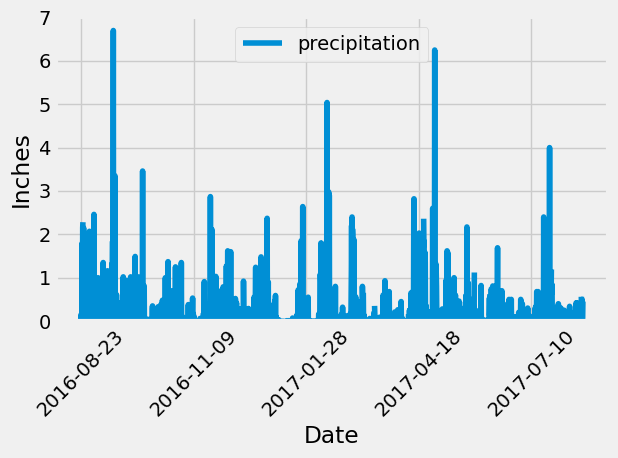

In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set. ie one year from the last date is 2016-08-23 which is accounted for
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['date', 'precipitation'])
prep_df = precipitation_df.set_index("date")
prep_df

# Use Pandas Plotting with Matplotlib to plot the data
prep_df.plot()
plt.ylim(0,7)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.savefig('Images/Hawaii_Precipitation', bbox_inches='tight')
plt.show()

In [33]:
# Use Pandas to calculate the summary statistics for the precipitation data
prep_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [42]:
# Design a query to calculate the total number of stations in the dataset
# Using SQLAlchemy 'distinct' library here
session.query(func.count(distinct(Measurement.station))).all()

[(9,)]

In [43]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
s_list = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*s_list).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [44]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Most active station is USC00519281
s_list = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
active_station = session.query(*s_list).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in active_station:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


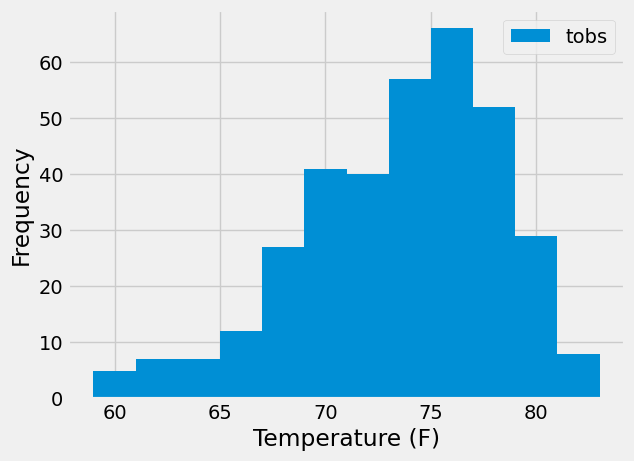

In [48]:
# Using the most active station id ie USC00519281
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')
start_date = recent_date - dt.timedelta(days=365)

s_list = [Measurement.date, 
       Measurement.tobs]
station_temp = session.query(*s_list).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Creating a dataframe containing the results of this query
station_temp_df = pd.DataFrame(station_temp, columns=['Date', 'Temperature'])

# Plotting results in a histogram
plt.hist(station_temp_df['Temperature'],bins=12, density=False, label="tobs")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend()
plt.figsize=(10,7)
plt.savefig('Images/USC00519281_Temps', bbox_inches='tight')
plt.show()

# Close Session

In [50]:
# Close Session
session.close()